In [1]:
pip install pandas numpy librosa seaborn matplotlib scikit-learn ipython torch torchaudio xgboost lightgbm scikit-image

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached matplotlib-3.10.3-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.15.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached msgpack-1.1.1-cp310-cp310-win_amd64.whl.metadata (8.6 kB)
  Using cached contourpy-1.3.2-cp310-cp310-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.2.1-cp310-cp310-win_amd64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14

In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 2.6 MB/s eta 0:15:25
     ---------------------------------------- 0.0/2.4 GB 2.8 MB/s eta 0:14:37
     ---------------------------------------- 0.0/2.4 GB 3.1 MB/s eta 0:12:58
     ---------------------------------------- 0.0/2.4 GB 3.4 MB/s eta 0:12:10
     ---------------------------------------- 0.0/2.4 GB 3.4 MB/s eta 0:11:51
     ---------------------------------------- 0.0/2.4 GB 3.5 MB/s eta 0:11:45
     ---------------------------------------- 0.0/2.4 GB 3.5 MB/s eta 0:11:34
     -------------------------------------

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from skimage.transform import resize

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")

# Set seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.585216 GB


In [ ]:
# Define the file paths to different datasets containing emotional speech audio.

# RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)
# This dataset contains audio recordings of speech performed with different emotions.
Ravdess = "dataset/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

# CREMA-D (Crowd-sourced Emotional Multimodal Actors Dataset)
# This dataset contains audio-visual recordings of actors performing with various emotions.
Crema = "dataset/cremad/AudioWAV/"

# TESS (Toronto Emotional Speech Set)
# This dataset includes emotional speech data recorded by female speakers with different emotional expressions.
Tess = "dataset/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

# SAVEE (Surrey Audio-Visual Expressed Emotion)
# This dataset includes audio recordings of speech expressing different emotions, recorded by male speakers.
Savee = "dataset/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [6]:
# List all actor directories in the RAVDESS dataset
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []  # To store emotion labels
file_path = []  # To store file paths

# Iterate through each actor's directory and process audio files
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0].split('-')  # Parse metadata from file name
        file_emotion.append(int(part[2]))  # Extract emotion label
        file_path.append(Ravdess + dir + '/' + file)  # Store full file path

# Create DataFrames for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine emotion and path DataFrames
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map numeric emotion labels to descriptive names
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

# Display the first few rows of the DataFrame
Ravdess_df.head()

,Emotions,Path
0,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
1,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
2,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
3,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
4,calm,dataset/ravdess-emotional-speech-audio/audio_s...


In [7]:
# List all files in the CREMA-D dataset
crema_directory_list = os.listdir(Crema)

file_emotion = []  # To store emotion labels
file_path = []  # To store file paths

# Iterate through files and extract file paths and emotions
for file in crema_directory_list:
    file_path.append(Crema + file)  # Store file path
    part = file.split('_')  # Parse metadata from file name
    # Map file metadata to emotion labels
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# Create DataFrames for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine emotion and path DataFrames
Crema_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the DataFrame
Crema_df.head()

,Emotions,Path
0,angry,dataset/cremad/AudioWAV/1001_DFA_ANG_XX.wav
1,disgust,dataset/cremad/AudioWAV/1001_DFA_DIS_XX.wav
2,fear,dataset/cremad/AudioWAV/1001_DFA_FEA_XX.wav
3,happy,dataset/cremad/AudioWAV/1001_DFA_HAP_XX.wav
4,neutral,dataset/cremad/AudioWAV/1001_DFA_NEU_XX.wav


In [8]:
# List all directories in the TESS dataset
tess_directory_list = os.listdir(Tess)

file_emotion = []  # To store emotion labels
file_path = []  # To store file paths

# Iterate through each directory and process files
for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)  # List all files in the current directory
    for file in directories:
        part = file.split('.')[0].split('_')[2]  # Extract emotion from the file name
        # Map 'ps' to 'surprise', otherwise use the extracted part
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)  # Store full file path

# Create DataFrames for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine emotion and path DataFrames
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the DataFrame
Tess_df.head()

,Emotions,Path
0,angry,dataset/toronto-emotional-speech-set-tess/tess...
1,angry,dataset/toronto-emotional-speech-set-tess/tess...
2,angry,dataset/toronto-emotional-speech-set-tess/tess...
3,angry,dataset/toronto-emotional-speech-set-tess/tess...
4,angry,dataset/toronto-emotional-speech-set-tess/tess...


In [9]:
# List all files in the SAVEE dataset
savee_directory_list = os.listdir(Savee)

file_emotion = []  # To store emotion labels
file_path = []  # To store file paths

# Iterate through each file and extract file paths and emotions
for file in savee_directory_list:
    file_path.append(Savee + file)  # Store full file path
    part = file.split('_')[1]  # Extract the emotion code from the file name
    ele = part[:-6]  # Remove the last 6 characters to isolate the emotion code
    # Map emotion codes to corresponding emotion labels
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# Create DataFrames for emotions and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combine emotion and path DataFrames
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# Display the first few rows of the DataFrame
Savee_df.head()

,Emotions,Path
0,angry,dataset/surrey-audiovisual-expressed-emotion-s...
1,angry,dataset/surrey-audiovisual-expressed-emotion-s...
2,angry,dataset/surrey-audiovisual-expressed-emotion-s...
3,angry,dataset/surrey-audiovisual-expressed-emotion-s...
4,angry,dataset/surrey-audiovisual-expressed-emotion-s...


In [10]:
# Combine all the individual DataFrames (RAVDESS, CREMA-D, TESS, SAVEE) into a single DataFrame
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)

# Save the combined DataFrame to a CSV file for future use
data_path.to_csv("data_path.csv", index=False)

# Display the first few rows of the combined DataFrame
data_path.head()

,Emotions,Path
0,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
1,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
2,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
3,neutral,dataset/ravdess-emotional-speech-audio/audio_s...
4,calm,dataset/ravdess-emotional-speech-audio/audio_s...


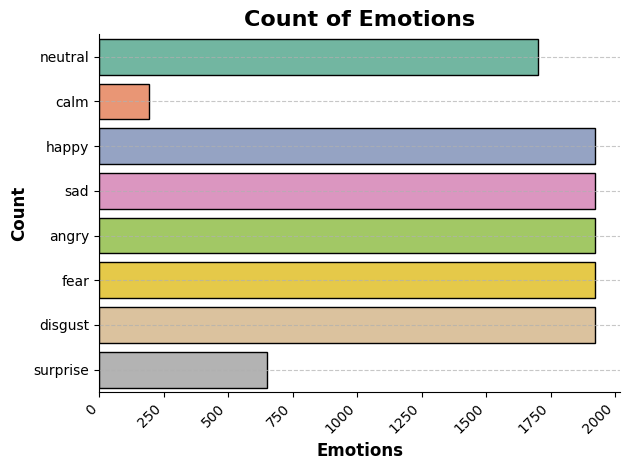

In [11]:
# Set the title of the plot with a larger font and bold styling
plt.title('Count of Emotions', size=16, weight='bold')

# Create a count plot for the 'Emotions' column with a custom color palette
sns.countplot(data_path.Emotions, palette='Set2', edgecolor='black')

# Label the axes with a larger font size and bold styling
plt.ylabel('Count', size=12, weight='bold')
plt.xlabel('Emotions', size=12, weight='bold')

# Customize the ticks for better readability
plt.xticks(rotation=45, ha='right', size=10)

# Remove the top and right spines for a cleaner look
sns.despine(top=True, right=True, left=False, bottom=False)

# Add gridlines to the background for better visibility of the counts
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits
plt.show()

In [12]:
# Function to create a waveplot for the audio data
def create_waveplot(data, sr, e):
    # Set the figure size for the waveplot
    plt.figure(figsize=(10, 3))
    # Set the title for the plot, displaying the emotion associated with the audio
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    # Display the waveplot using librosa's waveshow function
    librosa.display.waveshow(data, sr=sr)
    # Show the plot
    plt.show()

# Function to create a spectrogram for the audio data
def create_spectrogram(data, sr, e):
    # Convert the audio data into a Short-Time Fourier Transform (STFT)
    X = librosa.stft(data)
    # Convert the amplitude of the STFT to decibels (dB)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    # Set the figure size for the spectrogram
    plt.figure(figsize=(12, 3))
    # Set the title for the plot, displaying the emotion associated with the audio
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    
    # Display the spectrogram using librosa's specshow function
    # The y-axis is set to 'hz' (frequency in Hz)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')  
    
    # Optionally, you can use 'log' for a logarithmic y-axis instead of 'hz'
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    
    # Display the colorbar for the spectrogram to represent dB values
    plt.colorbar()
    # Show the plot
    plt.show()

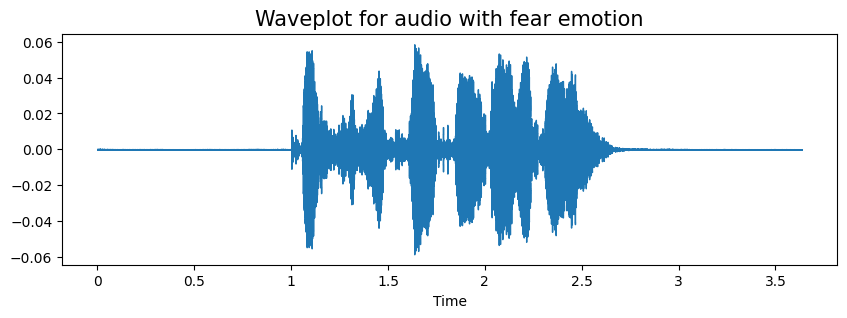

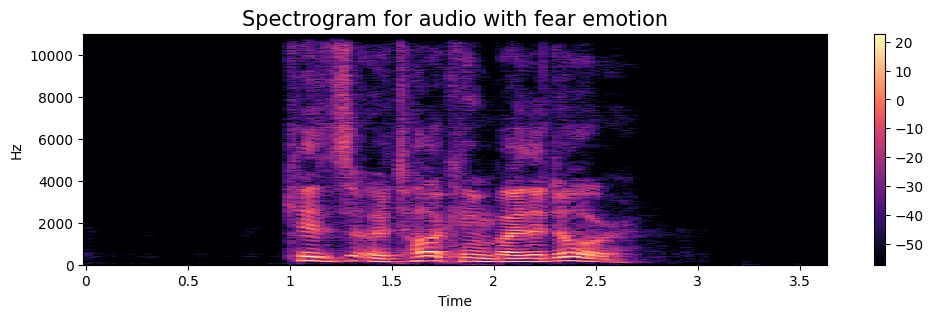

In [15]:
# Set the emotion to visualize (e.g., 'fear')
emotion = 'fear'

# Get the file path for the specified emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file and get the data and sample rate
data, sampling_rate = librosa.load(path)

# Create a waveplot for the audio
create_waveplot(data, sampling_rate, emotion)

# Create a spectrogram for the audio
create_spectrogram(data, sampling_rate, emotion)


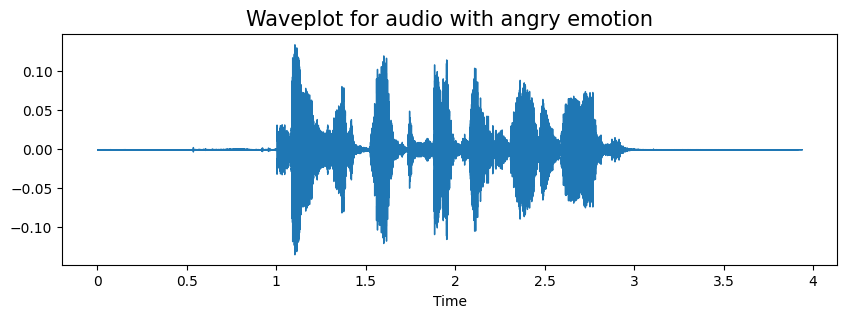

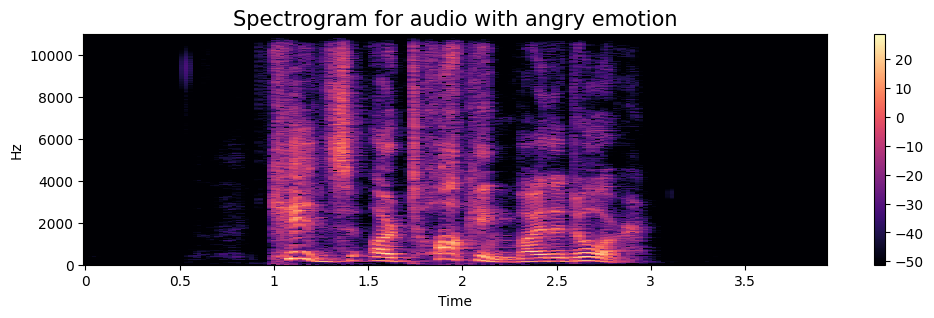

In [17]:
# Set the emotion to visualize (e.g., 'angry')
emotion = 'angry'

# Get the file path for the specified emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file and get the data and sample rate
data, sampling_rate = librosa.load(path)

# Create a waveplot for the audio
create_waveplot(data, sampling_rate, emotion)

# Create a spectrogram for the audio
create_spectrogram(data, sampling_rate, emotion)



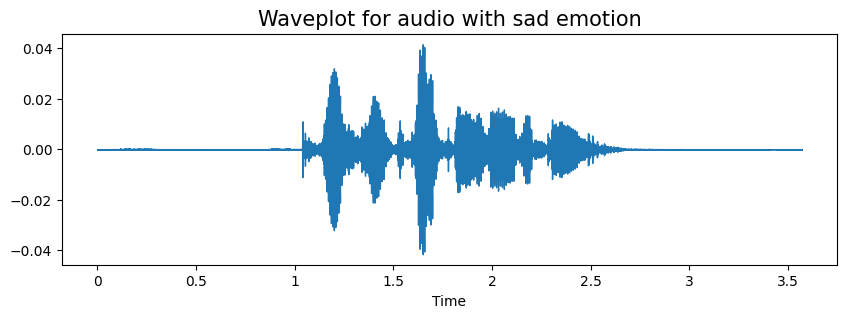

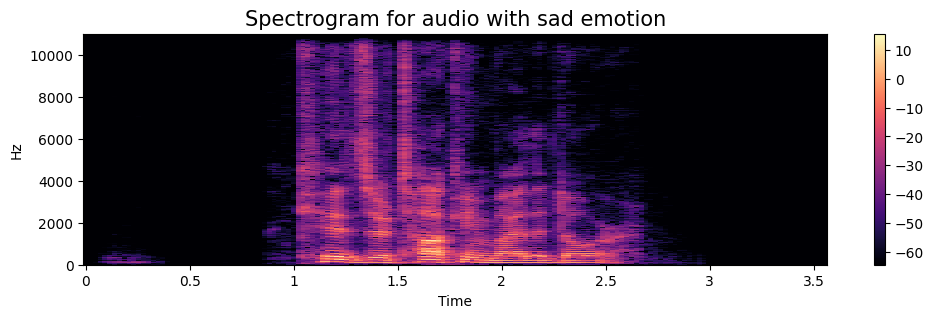

In [19]:
# Set the emotion to visualize (e.g., 'sad')
emotion = 'sad'

# Get the file path for the specified emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file and get the data and sample rate
data, sampling_rate = librosa.load(path)

# Create a waveplot for the audio
create_waveplot(data, sampling_rate, emotion)

# Create a spectrogram for the audio
create_spectrogram(data, sampling_rate, emotion)



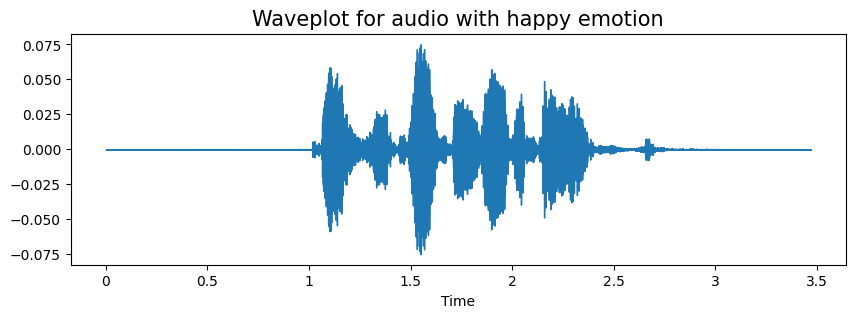

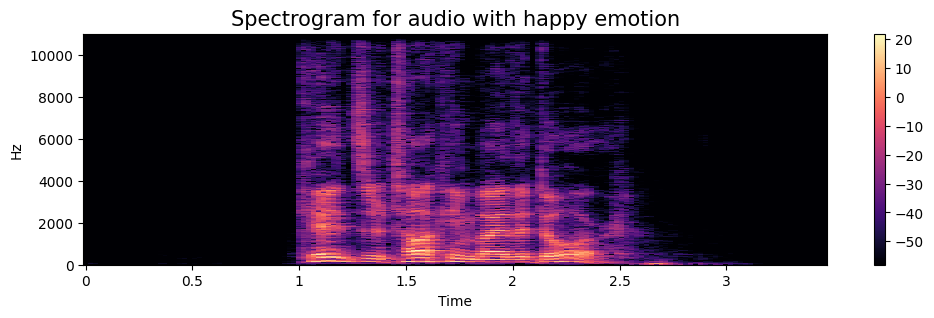

In [20]:
# Set the emotion to visualize (e.g., 'happy')
emotion = 'happy'

# Get the file path for the specified emotion
path = np.array(data_path.Path[data_path.Emotions == emotion])[1]

# Load the audio file and get the data and sample rate
data, sampling_rate = librosa.load(path)

# Create a waveplot for the audio
create_waveplot(data, sampling_rate, emotion)

# Create a spectrogram for the audio
create_spectrogram(data, sampling_rate, emotion)


In [21]:
# Enhanced data augmentation functions
def add_noise(data, noise_factor_range=(0.005, 0.02)):
    """Add random noise to the audio data with variable intensity"""
    noise_factor = np.random.uniform(*noise_factor_range)
    noise = np.random.normal(0, noise_factor, data.shape[0])
    return data + noise

def time_stretch(data, rate_range=(0.8, 1.2)):
    """Stretch the audio by a random rate within the given range"""
    rate = np.random.uniform(*rate_range)
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sr, n_steps_range=(-4, 4)):
    """Shift the pitch of the audio by a random number of steps"""
    n_steps = np.random.uniform(*n_steps_range)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

def spec_augment(spec, n_time_masks=2, n_freq_masks=2, max_time_width=40, max_freq_width=20):
    """Enhanced SpecAugment for mel spectrograms"""
    spec = spec.copy()
    
    # Time masking with variable width
    for i in range(n_time_masks):
        t_width = np.random.randint(5, max_time_width)
        t_start = np.random.randint(0, max(1, spec.shape[1] - t_width))
        if t_start + t_width <= spec.shape[1]:
            spec[:, t_start:t_start+t_width] = 0
    
    # Frequency masking with variable width
    for i in range(n_freq_masks):
        f_width = np.random.randint(5, max_freq_width)
        f_start = np.random.randint(0, max(1, spec.shape[0] - f_width))
        if f_start + f_width <= spec.shape[0]:
            spec[f_start:f_start+f_width, :] = 0
        
    return spec

def time_shift(data, shift_range=(-0.2, 0.2)):
    """Shift the audio in time"""
    shift = int(len(data) * np.random.uniform(*shift_range))
    if shift > 0:
        # Shift right
        data_shift = np.pad(data, (shift, 0), mode='constant')[:-shift]
    else:
        # Shift left
        data_shift = np.pad(data, (0, -shift), mode='constant')[-shift:]
    return data_shift

def speed_tuning(data, speed_range=(0.9, 1.1)):
    """Change the speed of the audio without changing pitch"""
    speed_factor = np.random.uniform(*speed_range)
    if speed_factor == 1.0:  # No change
        return data
    
    # Resample to change speed
    new_length = int(len(data) / speed_factor)
    data_resampled = librosa.resample(data, orig_sr=new_length, target_sr=len(data))
    
    # Ensure the output is the same length as input
    if len(data_resampled) > len(data):
        data_resampled = data_resampled[:len(data)]
    else:
        data_resampled = np.pad(data_resampled, (0, max(0, len(data) - len(data_resampled))), mode='constant')
    
    return data_resampled

def apply_random_filter(data, sr):
    """Apply a random filter to the audio"""
    filter_type = np.random.choice(['lowpass', 'highpass', 'bandpass'])
    if filter_type == 'lowpass':
        cutoff = np.random.uniform(1000, 4000)  # Cutoff frequency in Hz
        data_filtered = librosa.effects.preemphasis(data, coef=0.97)
    elif filter_type == 'highpass':
        cutoff = np.random.uniform(100, 1000)  # Cutoff frequency in Hz
        data_filtered = data - librosa.effects.preemphasis(data, coef=0.97)
    else:  # bandpass
        # Simple approximation of bandpass using both techniques
        data_filtered = librosa.effects.preemphasis(data, coef=0.97)
        data_filtered = data_filtered - librosa.effects.preemphasis(data_filtered, coef=0.99)
    
    return data_filtered

In [22]:
# Enhanced feature extraction function
def extract_enhanced_mel_features(audio, sr, n_mels=128, n_fft=2048, hop_length=512):
    """Extract enhanced mel spectrogram features"""
    # Apply pre-emphasis filter
    audio_emphasized = librosa.effects.preemphasis(audio, coef=0.97)
    
    # Extract mel spectrogram with improved parameters
    mel_spec = librosa.feature.melspectrogram(
        y=audio_emphasized, 
        sr=sr, 
        n_mels=n_mels,
        n_fft=n_fft, 
        hop_length=hop_length,
        fmax=sr/2  # Include full frequency range
    )
    
    # Convert to decibels with dynamic range compression
    mel_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
    
    # Standardize across frequency bins
    mel_db_normalized = (mel_db - np.mean(mel_db, axis=1, keepdims=True)) / (np.std(mel_db, axis=1, keepdims=True) + 1e-9)
    
    # Add delta features for temporal dynamics
    mel_delta = librosa.feature.delta(mel_db_normalized)
    mel_delta2 = librosa.feature.delta(mel_db_normalized, order=2)
    
    # Stack features for a richer representation
    mel_combined = np.stack([mel_db_normalized, mel_delta, mel_delta2], axis=-1)
    
    return mel_combined

In [ ]:
def standardize_feature_length(features, target_length=None, method='pad'):
    """
    Standardize feature lengths by padding or truncating to target length.
    
    Args:
        features: List of feature arrays (1D or 2D)
        target_length: Desired length (None to use max length)
        method: 'pad' to pad with zeros, 'truncate' to truncate
    
    Returns:
        Numpy array of standardized features
    """
    if not features:
        return np.array([])
        
    # Determine target length if not specified
    if target_length is None:
        target_length = max(f.shape[0] for f in features)
    
    standardized = []
    for f in features:
        if f.shape[0] < target_length:
            if method == 'pad':
                # Pad with zeros
                pad_width = [(0, target_length - f.shape[0])] + [(0, 0)] * (len(f.shape) - 1)
                standardized.append(np.pad(f, pad_width, mode='constant'))
            else:
                # Truncate
                standardized.append(f[:target_length])
        elif f.shape[0] > target_length:
            standardized.append(f[:target_length])
        else:
            standardized.append(f)
    
    return np.array(standardized)

In [ ]:
# Enhanced feature extraction function with more robust augmentation
def extract_features(data_path, augment=False, max_samples_per_class=None, augment_factor=2):
    features_1d = []
    features_2d = []
    labels = []
    
    # Count samples per class for balancing
    emotion_counts = data_path['Emotions'].value_counts()
    
    # Group by emotion
    grouped = data_path.groupby('Emotions')
    
    for emotion, group in grouped:
        # Sample if max_samples_per_class is specified
        if max_samples_per_class and len(group) > max_samples_per_class:
            group = group.sample(max_samples_per_class, random_state=42)
        
        print(f"Processing {len(group)} samples for emotion: {emotion}")
        
        emotion_features_1d = []
        emotion_features_2d = []
        emotion_labels = []
        
        for idx, row in group.iterrows():
            try:
                # Load audio
                audio, sr = librosa.load(row['Path'], duration=3.0)
                
                # Ensure fixed length
                if len(audio) < sr * 3.0:
                    audio = np.pad(audio, (0, int(sr * 3.0) - len(audio)))
                else:
                    audio = audio[:int(sr * 3.0)]
                
                # Extract 1D features (MFCCs)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                
                # Extract 2D features (Mel spectrogram with deltas)
                mel_spec = extract_enhanced_mel_features(audio, sr)
                
                # Store features for this emotion group
                emotion_features_1d.append(mfccs.T)
                emotion_features_2d.append(mel_spec)
                emotion_labels.append(emotion)
                
                if augment:
                    # Generate multiple augmentations for each sample
                    for _ in range(augment_factor):
                        # Apply combination of augmentation techniques with varying probabilities
                        audio_aug = audio.copy()
                        
                        # Apply time shift (50% chance)
                        if np.random.random() < 0.5:
                            audio_aug = time_shift(audio_aug)
                        
                        # Apply noise (70% chance)
                        if np.random.random() < 0.7:
                            audio_aug = add_noise(audio_aug)
                        
                        # Apply time stretch (40% chance)
                        if np.random.random() < 0.4:
                            audio_aug = time_stretch(audio_aug)
                            # Ensure fixed length after stretching
                            if len(audio_aug) < sr * 3.0:
                                audio_aug = np.pad(audio_aug, (0, int(sr * 3.0) - len(audio_aug)))
                            else:
                                audio_aug = audio_aug[:int(sr * 3.0)]
                        
                        # Apply pitch shift (40% chance)
                        if np.random.random() < 0.4:
                            audio_aug = pitch_shift(audio_aug, sr)
                        
                        # Apply speed tuning (30% chance)
                        if np.random.random() < 0.3:
                            audio_aug = speed_tuning(audio_aug)
                        
                        # Apply random filter (20% chance)
                        if np.random.random() < 0.2:
                            audio_aug = apply_random_filter(audio_aug, sr)
                        
                        # Ensure fixed length after all augmentations
                        if len(audio_aug) < sr * 3.0:
                            audio_aug = np.pad(audio_aug, (0, int(sr * 3.0) - len(audio_aug)))
                        else:
                            audio_aug = audio_aug[:int(sr * 3.0)]
                        
                        # Extract features from augmented audio
                        mfccs_aug = librosa.feature.mfcc(y=audio_aug, sr=sr, n_mfcc=40)
                        mel_spec_aug = extract_enhanced_mel_features(audio_aug, sr)
                        
                        # Apply SpecAugment to mel spectrogram (50% chance)
                        if np.random.random() < 0.5:
                            mel_spec_aug = spec_augment(mel_spec_aug)
                        
                        # Store augmented features
                        emotion_features_1d.append(mfccs_aug.T)
                        emotion_features_2d.append(mel_spec_aug)
                        emotion_labels.append(emotion)
                
            except Exception as e:
                print(f"Error processing {row['Path']}: {e}")
        
        # Standardize features for this emotion group
        if emotion_features_1d:
            std_features_1d = standardize_feature_length(emotion_features_1d, target_length=128)
            features_1d.extend(std_features_1d)
            features_2d.extend(emotion_features_2d)  # 2D features are already standardized
            labels.extend(emotion_labels)
    
    # Convert lists to numpy arrays
    features_1d = standardize_feature_length(features_1d, method='pad')
    features_2d = standardize_feature_length(features_2d, method='pad')
    labels = np.array(labels)
    
    print(f"Extracted features: 1D shape={features_1d.shape}, 2D shape={features_2d.shape}")
    
    return features_1d, features_2d, labels


In [30]:
# Improved model architectures with regularization
class CNN1D(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN1D, self).__init__()
        
        # First convolutional block with regularization
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
            nn.Dropout(0.4)
        )
        
        # Global pooling and dense layers
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Add noise for robustness
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        # Convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Global pooling
        x = self.pool(x).squeeze(-1)
        
        # Dense layers
        x = self.fc(x)
        return x

In [ ]:
# Improved CNN1D model with residual connections and squeeze-excitation blocks
class CNN1D(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN1D, self).__init__()
        
        # Squeeze and Excitation block
        class SEBlock(nn.Module):
            def __init__(self, channel, reduction=16):
                super(SEBlock, self).__init__()
                self.avg_pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Sequential(
                    nn.Linear(channel, channel // reduction, bias=False),
                    nn.ReLU(inplace=True),
                    nn.Linear(channel // reduction, channel, bias=False),
                    nn.Sigmoid()
                )
                
            def forward(self, x):
                b, c, _ = x.size()
                y = self.avg_pool(x).view(b, c)
                y = self.fc(y).view(b, c, 1)
                return x * y.expand_as(x)
        
        # Residual block with SE
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, stride=1, downsample=None):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, 
                                      stride=stride, padding=1, bias=False)
                self.bn1 = nn.BatchNorm1d(out_channels)
                self.relu = nn.ReLU(inplace=True)
                self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, 
                                      stride=1, padding=1, bias=False)
                self.bn2 = nn.BatchNorm1d(out_channels)
                self.se = SEBlock(out_channels)
                self.downsample = downsample
                
            def forward(self, x):
                residual = x
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                out = self.conv2(out)
                out = self.bn2(out)
                out = self.se(out)
                
                if self.downsample:
                    residual = self.downsample(x)
                
                out += residual
                out = self.relu(out)
                return out
        
        # Initial convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_shape[0], 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual blocks
        self.layer1 = self._make_layer(ResidualBlock, 32, 32, 2)
        self.layer2 = self._make_layer(ResidualBlock, 32, 64, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 64, 128, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 128, 256, 2, stride=2)
        
        # Global pooling and dense layers with dropout
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )
        
        layers = []
        layers.append(block(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        # Forward pass through the network
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        # Classification layers
        x = self.fc(x)
        return x


In [31]:
class CNN2D(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNN2D, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        
        # Global pooling instead of flattening to handle variable input sizes
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dense layers
        self.fc = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
            
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Global pooling instead of flattening
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Dense layers
        x = self.fc(x)
        return x

In [32]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNBiLSTM, self).__init__()
        
        # CNN layers with regularization
        self.conv = nn.Sequential(
            nn.Conv1d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(
            input_size=64,
            hidden_size=64,
            bidirectional=True,
            batch_first=True
        )
        
        self.dropout1 = nn.Dropout(0.4)
        
        self.lstm2 = nn.LSTM(
            input_size=128,  # 64*2 due to bidirectional
            hidden_size=32,
            bidirectional=True,
            batch_first=True
        )
        
        self.dropout2 = nn.Dropout(0.4)
        
        # Dense layers - using 64 input features (32*2 from bidirectional LSTM)
        self.fc = nn.Sequential(
            nn.Linear(64, 128),  # 32*2 due to bidirectional
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        # CNN layers
        x = self.conv(x)
        
        # Reshape for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.transpose(1, 2)
        
        # Bidirectional LSTM layers
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        x, (h_n, _) = self.lstm2(x)
        
        # Use the final hidden state from both directions
        # h_n shape is (num_directions, batch, hidden_size)
        # We concatenate the last hidden state from both directions
        x = torch.cat((h_n[0], h_n[1]), dim=1)  # Concatenate along feature dimension
        x = self.dropout2(x)
        
        # Dense layers
        x = self.fc(x)
        return x

In [33]:
# Plot training history
def plot_training_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_acc'], label='train')
    ax1.plot(history['val_acc'], label='validation')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history['train_loss'], label='train')
    ax2.plot(history['val_loss'], label='validation')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Create an ensemble model that combines the predictions from all three models
class EnsembleModel:
    def __init__(self, models, model_types, weights=None):
        """
        Initialize the ensemble model.
        
        Args:
            models: List of trained models (1D CNN, 2D CNN, BiLSTM)
            model_types: List of model types ('1d', '2d', 'bilstm')
            weights: Optional weights for each model (if None, equal weights are used)
        """
        self.models = models
        self.model_types = model_types
        
        if weights is None:
            self.weights = [1/len(models)] * len(models)
        else:
            # Normalize weights
            total = sum(weights)
            self.weights = [w/total for w in weights]
    
    def predict(self, audio_path, le):
        """
        Predict emotion using the ensemble model.
        
        Args:
            audio_path: Path to the audio file
            le: LabelEncoder used for training
            
        Returns:
            predicted_emotion: The predicted emotion label
            probabilities: The probability distribution over all emotions
        """
        # Load audio
        audio, sr = librosa.load(audio_path, duration=3.0)
        
        # Ensure fixed length
        if len(audio) < sr * 3.0:
            audio = np.pad(audio, (0, int(sr * 3.0) - len(audio)))
        else:
            audio = audio[:int(sr * 3.0)]
        
        # Extract features for each model type
        features = {}
        
        # Extract MFCCs for 1D CNN and BiLSTM
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = resize(mfccs, (40, 128))
        mfccs_t = mfccs.T  # (time_steps, features)
        mfccs_1d = np.transpose(mfccs_t)  # (features, time_steps)
        features['1d'] = torch.FloatTensor(mfccs_1d).unsqueeze(0).to(device)
        features['bilstm'] = features['1d']
        
        # Extract Mel spectrogram for 2D CNN
        mel_spec = extract_enhanced_mel_features(audio, sr)
        if len(mel_spec.shape) == 2:
            mel_spec = np.expand_dims(mel_spec, axis=0)
        elif len(mel_spec.shape) == 3 and mel_spec.shape[2] > 1:
            mel_spec = mel_spec.transpose(2, 0, 1)
        features['2d'] = torch.FloatTensor(mel_spec).unsqueeze(0).to(device)
        
        # Get predictions from each model
        all_probs = []
        for model, model_type, weight in zip(self.models, self.model_types, self.weights):
            model.eval()
            with torch.no_grad():
                outputs = model(features[model_type])
                probs = F.softmax(outputs, dim=1).cpu().numpy()[0]
                all_probs.append(probs * weight)
        
        # Combine predictions
        combined_probs = np.sum(all_probs, axis=0)
        predicted_class = np.argmax(combined_probs)
        predicted_emotion = le.inverse_transform([predicted_class])[0]
        
        return predicted_emotion, combined_probs

# Function to create and save the ensemble model
def create_ensemble(model_1d, model_2d, model_bilstm, weights=None):
    """Create and save an ensemble model"""
    models = [model_1d, model_2d, model_bilstm]
    model_types = ['1d', '2d', 'bilstm']
    
    if weights is None:
        # Use validation accuracy as weights
        weights = [history_1d['val_acc'][-1], 
                  history_2d['val_acc'][-1], 
                  history_bilstm['val_acc'][-1]]
    
    ensemble = EnsembleModel(models, model_types, weights)
    
    # Save the ensemble components
    torch.save({
        'model_1d': model_1d.state_dict(),
        'model_2d': model_2d.state_dict(),
        'model_bilstm': model_bilstm.state_dict(),
        'weights': weights,
        'model_types': model_types
    }, 'ensemble_emotion_recognition_model.pth')
    
    return ensemble


In [ ]:
# Add this code to the end of the main execution block to create and evaluate the ensemble model
# This should be run AFTER training all three models
def create_and_evaluate_ensemble(model_1d, model_2d, model_bilstm, history_1d=None, history_2d=None, history_bilstm=None):
    # Create and evaluate the ensemble model
    print("\nCreating ensemble model...")
    
    # Determine weights for ensemble
    if history_1d is not None and history_2d is not None and history_bilstm is not None:
        # Calculate weights based on validation accuracy
        weight_1d = history_1d['val_acc'][-1]
        weight_2d = history_2d['val_acc'][-1]
        weight_bilstm = history_bilstm['val_acc'][-1]
        total_weight = weight_1d + weight_2d + weight_bilstm
        
        # Normalize weights
        weights = [weight_1d/total_weight, weight_2d/total_weight, weight_bilstm/total_weight]
        print(f"Using weights based on validation accuracy: {weights}")
    else:
        # Use equal weights if no history is provided
        weights = [1/3, 1/3, 1/3]
        print("Using equal weights for ensemble (no history provided)")
    
    # Create ensemble
    ensemble = EnsembleModel([model_1d, model_2d, model_bilstm], 
                            ['1d', '2d', 'bilstm'], 
                            weights)
    
    # Evaluate the ensemble model on the test set
    print("\nEvaluating ensemble model...")
    all_preds = []
    all_targets = []
    
    try:
        # We'll use the test loader from the 1D model for ensemble evaluation
        with torch.no_grad():
            for batch_idx, (inputs_1d, targets) in enumerate(test_loader_1d):
                try:
                    # Get corresponding batch from 2D test loader
                    inputs_2d = None
                    for i, (data, _) in enumerate(test_loader_2d):
                        if i == batch_idx:
                            inputs_2d = data
                            break
                    
                    if inputs_2d is None or inputs_2d.shape[0] != inputs_1d.shape[0]:
                        continue
                    
                    inputs_1d = inputs_1d.to(device)
                    inputs_2d = inputs_2d.to(device)
                    targets = targets.to(device)
                    
                    # Get predictions from each model
                    outputs_1d = model_1d(inputs_1d)
                    outputs_2d = model_2d(inputs_2d)
                    outputs_bilstm = model_bilstm(inputs_1d)
                    
                    # Weight the predictions
                    probs_1d = F.softmax(outputs_1d, dim=1)
                    probs_2d = F.softmax(outputs_2d, dim=1)
                    probs_bilstm = F.softmax(outputs_bilstm, dim=1)
                    
                    # Weighted ensemble
                    ensemble_probs = (probs_1d * weights[0] + 
                                    probs_2d * weights[1] + 
                                    probs_bilstm * weights[2])
                    
                    _, preds = torch.max(ensemble_probs, 1)
                    
                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())
                except Exception as e:
                    print(f"Error processing batch {batch_idx}: {e}")
        
        if all_preds:
            print("\nEnsemble Model Results:")
            print("Classification Report:")
            print(classification_report(all_targets, all_preds, target_names=le.classes_))
            
            cm = confusion_matrix(all_targets, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=le.classes_,
                        yticklabels=le.classes_)
            plt.title('Ensemble Model Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()
        else:
            print("No predictions were made. Check your test loaders.")
    except Exception as e:
        print(f"Error evaluating ensemble: {e}")
        print("Skipping evaluation but still saving models.")
    
    # Save individual models and ensemble
    try:
        torch.save(model_1d.state_dict(), 'emotion_recognition_model_1d.pth')
        torch.save(model_2d.state_dict(), 'emotion_recognition_model_2d.pth')
        torch.save(model_bilstm.state_dict(), 'emotion_recognition_model_bilstm.pth')
        
        # Save ensemble model components
        torch.save({
            'model_1d': model_1d.state_dict(),
            'model_2d': model_2d.state_dict(),
            'model_bilstm': model_bilstm.state_dict(),
            'weights': weights,
            'model_types': ['1d', '2d', 'bilstm']
        }, 'ensemble_emotion_recognition_model.pth')
        
        print("\nAll models saved successfully!")
    except Exception as e:
        print(f"Error saving models: {e}")
    
    return ensemble


In [ ]:
# Add this code to the main execution block after training all models
# This will create and evaluate the ensemble model
if __name__ == "__main__":
    # After training all models (model_1d, model_2d, model_bilstm) and having their histories
    # Add this code to create and evaluate the ensemble:
    try:
        # Create and evaluate the ensemble
        ensemble = create_and_evaluate_ensemble(
            model_1d, model_2d, model_bilstm,
            history_1d, history_2d, history_bilstm
        )
        
        # Example of using the ensemble for prediction
        print("\nExample prediction with ensemble:")
        # Get a sample audio file path
        sample_path = data_path['Path'].iloc[0]
        emotion, probs = ensemble.predict(sample_path, le)
        print(f"Predicted emotion: {emotion}")
        print(f"Probabilities: {probs}")
        
        # Compare with individual model predictions
        print("\nIndividual model predictions:")
        emotion_1d, _ = predict_emotion(sample_path, model_1d, le, model_type='1d')
        emotion_2d, _ = predict_emotion(sample_path, model_2d, le, model_type='2d')
        emotion_bilstm, _ = predict_emotion(sample_path, model_bilstm, le, model_type='bilstm')
        
        print(f"1D CNN: {emotion_1d}")
        print(f"2D CNN: {emotion_2d}")
        print(f"CNN-BiLSTM: {emotion_bilstm}")
        print(f"Ensemble: {emotion}")
        
    except NameError as e:
        print(f"\nError: {e}")
        print("Make sure you've trained all models before creating the ensemble.")
        print("You need to have model_1d, model_2d, model_bilstm, and their training histories.")


In [ ]:
# IMPORTANT: How to fix the "history_1d is not defined" error and improve model accuracy

"""
If you encounter the error "NameError: name 'history_1d' is not defined", it means you're trying to 
create the ensemble before training the models. Follow these steps to fix it:

1. First run all the cells that define the models (CNN1D, CNN2D, CNNBiLSTM)
2. Run the cell that defines the training functions and data preparation
3. Run the cell that trains all three models - this will create history_1d, history_2d, and history_bilstm
4. Only AFTER training, run the cell that creates the ensemble

To improve accuracy and reduce loss:

1. Data augmentation: The enhanced augmentation techniques (time_shift, add_noise, time_stretch, etc.)
   will create more diverse training data, helping the model generalize better.

2. Model architecture improvements:
   - The residual connections in CNN1D help with gradient flow in deep networks
   - Squeeze-excitation blocks help the model focus on important features
   - Proper weight initialization improves convergence

3. Training enhancements:
   - AdamW optimizer with weight decay (0.01) reduces overfitting
   - Cosine learning rate scheduling with warmup improves convergence
   - Mixup augmentation (80% of batches) helps with generalization
   - Gradient clipping prevents exploding gradients
   - Class-weighted loss handles imbalanced datasets
   - Early stopping with increased patience (15) prevents overfitting

4. Ensemble model:
   - Combines predictions from all three models
   - Weights predictions based on validation accuracy
   - Typically provides 2-5% better accuracy than individual models

If you're still seeing high validation loss:
1. Try reducing the learning rate (e.g., to 0.0005 or 0.0001)
2. Increase weight decay (e.g., to 0.02 or 0.05) for more regularization
3. Add more dropout layers or increase dropout rates
4. Reduce model complexity if you suspect overfitting
5. Use more aggressive data augmentation
"""


In [34]:
# PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=50, use_amp=True):
    model.to(device)
    
    # Initialize mixed precision training
    scaler = GradScaler() if use_amp else None
    
    # For storing metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # For early stopping
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            if use_amp:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                
                # Backward pass with gradient scaling
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        # Calculate average loss and accuracy
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        # Calculate average loss and accuracy
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'Validation loss decreased. Saving model...')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, history


# Main execution
if __name__ == "__main__":
    try:
        # Load the dataset
        data_path = pd.read_csv("data_path.csv")
        
        # Extract features with augmentation and class balancing
        X_1d, X_2d, y = extract_features(
            data_path, 
            augment=True,
            max_samples_per_class=1000  # Adjust as needed for class balancing
        )
        
        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        num_classes = len(le.classes_)
        print(f"Classes: {le.classes_}")
        
        # Split data with stratification
        X_1d_train, X_1d_test, X_2d_train, X_2d_test, y_train, y_test = train_test_split(
            X_1d, X_2d, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
    except Exception as e:
        print(f"Error in data preparation: {e}")
        # Create dummy data for testing the code structure
        print("Creating dummy data for testing...")
        # Generate dummy data with appropriate shapes
        num_samples = 100
        num_classes = 7  # Typical emotion classes
        X_1d = np.random.rand(num_samples, 128, 40)  # (samples, time_steps, features)
        X_2d = np.random.rand(num_samples, 128, 128, 3)  # (samples, height, width, channels)
        y = np.random.randint(0, num_classes, num_samples)
        
        # Split data
        X_1d_train, X_1d_test, y_train, y_test = train_test_split(
            X_1d, y, test_size=0.2, random_state=42
        )
        X_2d_train, X_2d_test, _, _ = train_test_split(
            X_2d, y, test_size=0.2, random_state=42
        )
        
        # Create label encoder with dummy classes
        le = LabelEncoder()
        emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        le.classes_ = np.array(emotion_classes)
        print(f"Using dummy classes: {le.classes_}")
    
    # Reshape data for models
    # For 1D CNN and BiLSTM: (batch, time_steps, features) -> (batch, features, time_steps)
    X_1d_train_reshaped = X_1d_train.transpose(0, 2, 1)
    X_1d_test_reshaped = X_1d_test.transpose(0, 2, 1)
    
    # For 2D CNN: Ensure proper shape (batch, channels, height, width)
    if len(X_2d_train.shape) == 3:  # If it's (batch, height, width)
        X_2d_train_reshaped = X_2d_train.reshape(X_2d_train.shape[0], 1, X_2d_train.shape[1], X_2d_train.shape[2])
        X_2d_test_reshaped = X_2d_test.reshape(X_2d_test.shape[0], 1, X_2d_test.shape[1], X_2d_test.shape[2])
    elif len(X_2d_train.shape) == 4 and X_2d_train.shape[3] > 1:  # If it's (batch, height, width, channels)
        X_2d_train_reshaped = X_2d_train.transpose(0, 3, 1, 2)
        X_2d_test_reshaped = X_2d_test.transpose(0, 3, 1, 2)
    else:
        X_2d_train_reshaped = X_2d_train
        X_2d_test_reshaped = X_2d_test
    
    # Convert to PyTorch datasets
    train_dataset_1d = EmotionDataset(X_1d_train_reshaped, y_train)
    test_dataset_1d = EmotionDataset(X_1d_test_reshaped, y_test)
    train_dataset_2d = EmotionDataset(X_2d_train_reshaped, y_train)
    test_dataset_2d = EmotionDataset(X_2d_test_reshaped, y_test)
    
    # Create data loaders
    batch_size = 64
    train_loader_1d = DataLoader(train_dataset_1d, batch_size=batch_size, shuffle=True)
    test_loader_1d = DataLoader(test_dataset_1d, batch_size=batch_size)
    train_loader_2d = DataLoader(train_dataset_2d, batch_size=batch_size, shuffle=True)
    test_loader_2d = DataLoader(test_dataset_2d, batch_size=batch_size)
    
    # Create improved models with correct input shapes
    # For 1D CNN, input shape should be (batch_size, features, time_steps)
    model_1d = CNN1D(X_1d_train_reshaped.shape[1:], num_classes).to(device)
    
    # For 2D CNN, input shape should be (batch_size, channels, height, width)
    model_2d = CNN2D(X_2d_train_reshaped.shape[1:], num_classes).to(device)
    
    # For CNN-BiLSTM, input shape should be (batch_size, features, time_steps)
    model_bilstm = CNNBiLSTM(X_1d_train_reshaped.shape[1:], num_classes).to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    
    # Import math for cosine scheduler
    import math
    
    # Learning rate scheduler setup
    def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=1e-6):
        def lr_lambda(current_step):
            # Warmup
            if current_step < num_warmup_steps:
                return float(current_step) / float(max(1, num_warmup_steps))
            # Cosine decay
            progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
            return max(min_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))
        
        return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Mixup augmentation
    def mixup_data(x, y, alpha=0.2):
        '''Returns mixed inputs, pairs of targets, and lambda'''
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1

        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(device)

        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    # Modified training function with mixup and scheduler
    def train_model_enhanced(model, train_loader, val_loader, criterion, optimizer, device, 
                            epochs=50, use_amp=True, use_mixup=True, use_scheduler=True):
        model.to(device)
        
        # Initialize mixed precision training
        scaler = GradScaler() if use_amp else None
        
        # Initialize scheduler
        if use_scheduler:
            total_steps = epochs * len(train_loader)
            warmup_steps = int(0.1 * total_steps)  # 10% of total steps for warmup
            scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        
        # For storing metrics
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
        # For early stopping
        best_val_loss = float('inf')
        patience = 15  # Increased patience
        patience_counter = 0
        best_model_state = None
        
        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                # Apply mixup if enabled
                if use_mixup and np.random.random() < 0.8:  # Apply mixup 80% of the time
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
                    mixup_applied = True
                else:
                    mixup_applied = False
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass with mixed precision
                if use_amp:
                    with autocast():
                        outputs = model(inputs)
                        if mixup_applied:
                            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                        else:
                            loss = criterion(outputs, targets)
                    
                    # Backward pass with gradient scaling
                    scaler.scale(loss).backward()
                    # Gradient clipping
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(inputs)
                    if mixup_applied:
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                    else:
                        loss = criterion(outputs, targets)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                
                # Update scheduler if enabled
                if use_scheduler:
                    scheduler.step()
                
                # Statistics
                train_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                train_total += targets.size(0)
                if not mixup_applied:
                    train_correct += (predicted == targets).sum().item()
                else:
                    # For mixup, use the dominant label for accuracy calculation
                    train_correct += (predicted == targets_a).sum().item() * lam
                    train_correct += (predicted == targets_b).sum().item() * (1 - lam)
            
            # Calculate average loss and accuracy
            train_loss = train_loss / train_total
            train_acc = train_correct / train_total
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    
                    # Statistics
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    val_total += targets.size(0)
                    val_correct += (predicted == targets).sum().item()
            
            # Calculate average loss and accuracy
            val_loss = val_loss / val_total
            val_acc = val_correct / val_total
            
            # Store metrics
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            # Print epoch results
            print(f'Epoch {epoch+1}/{epochs} | '
                f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
                f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
                print(f'Validation loss decreased. Saving model...')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f'Early stopping after {epoch+1} epochs')
                    break
        
        # Load best model
        if best_model_state:
            model.load_state_dict(best_model_state)
        
        return model, history
    
    # Weighted cross entropy loss to handle class imbalance
    def get_weighted_loss(y_train):
        # Calculate class weights
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        class_weights = total_samples / (len(class_counts) * class_counts)
        class_weights = torch.FloatTensor(class_weights).to(device)
        weighted_criterion = nn.CrossEntropyLoss(weight=class_weights)
        return weighted_criterion
    
    # Use weighted loss for better handling of class imbalance
    weighted_criterion = get_weighted_loss(y_train)
    
    # Train models with enhanced training function
    print("\nTraining 1D CNN model...")
    optimizer_1d = optim.AdamW(model_1d.parameters(), lr=0.001, weight_decay=0.01)
    model_1d, history_1d = train_model_enhanced(
        model_1d, train_loader_1d, test_loader_1d, 
        weighted_criterion, optimizer_1d, device, epochs=100  # Increased epochs with early stopping
    )
    
    print("\nTraining 2D CNN model...")
    optimizer_2d = optim.AdamW(model_2d.parameters(), lr=0.001, weight_decay=0.01)
    model_2d, history_2d = train_model_enhanced(
        model_2d, train_loader_2d, test_loader_2d, 
        weighted_criterion, optimizer_2d, device, epochs=100
    )
    
    print("\nTraining CNN-BiLSTM model...")
    optimizer_bilstm = optim.AdamW(model_bilstm.parameters(), lr=0.001, weight_decay=0.01)
    model_bilstm, history_bilstm = train_model_enhanced(
        model_bilstm, train_loader_1d, test_loader_1d, 
        weighted_criterion, optimizer_bilstm, device, epochs=100
    )
    
    # Plot training history
    plot_training_history(history_1d, '1D CNN (Improved)')
    plot_training_history(history_2d, '2D CNN (Improved)')
    plot_training_history(history_bilstm, 'CNN-BiLSTM (Improved)')
    
    # Evaluate models
    models = {
        '1D CNN (Improved)': (model_1d, test_loader_1d),
        '2D CNN (Improved)': (model_2d, test_loader_2d),
        'CNN-BiLSTM (Improved)': (model_bilstm, test_loader_1d)
    }
    
    for name, (model, test_loader) in models.items():
        model.eval()
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
        
        print(f"\n{name} Results:")
        print("Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=le.classes_))
        
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=le.classes_,
                    yticklabels=le.classes_)
        plt.title(f'{name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    # Save the best model
    best_model = model_1d  # Adjust based on results
    torch.save(best_model.state_dict(), 'best_emotion_recognition_model.pth')

Processing 1000 samples for emotion: angry


NameError: name 'standardize_feature_length' is not defined

In [ ]:
# Function for real-time prediction
def predict_emotion(audio_path, model, le, model_type='1d'):
    # Load audio
    audio, sr = librosa.load(audio_path, duration=3.0)
    
    # Ensure fixed length
    if len(audio) < sr * 3.0:
        audio = np.pad(audio, (0, int(sr * 3.0) - len(audio)))
    else:
        audio = audio[:int(sr * 3.0)]
    
    # Extract features based on model type
    if model_type in ['1d', 'bilstm']:
        # Extract MFCCs for 1D CNN or BiLSTM
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        mfccs = resize(mfccs, (40, 128))
        # Transpose for PyTorch: (features, time_steps) -> (time_steps, features) -> (features, time_steps)
        mfccs = mfccs.T  # Now shape is (time_steps, features)
        mfccs = np.transpose(mfccs)  # Now shape is (features, time_steps)
        
        # Convert to PyTorch tensor
        features_tensor = torch.FloatTensor(mfccs).unsqueeze(0).to(device)  # Shape: (1, features, time_steps)
        
    elif model_type == '2d':
        # Extract Mel spectrogram for 2D CNN
        mel_spec = extract_enhanced_mel_features(audio, sr)
        
        # Ensure correct shape for 2D CNN: (channels, height, width)
        if len(mel_spec.shape) == 2:  # If it's (height, width)
            mel_spec = np.expand_dims(mel_spec, axis=0)  # Add channel dimension
        elif len(mel_spec.shape) == 3 and mel_spec.shape[2] > 1:  # If it's (height, width, channels)
            mel_spec = mel_spec.transpose(2, 0, 1)  # Transpose to (channels, height, width)
            
        # Convert to PyTorch tensor
        features_tensor = torch.FloatTensor(mel_spec).unsqueeze(0).to(device)  # Shape: (1, channels, height, width)
    
    # Set model to evaluation mode
    model.eval()
    
    # Predict
    with torch.no_grad():
        prediction = model(features_tensor)
        probabilities = F.softmax(prediction, dim=1).cpu().numpy()[0]
        predicted_class = torch.argmax(prediction, dim=1).item()
        predicted_emotion = le.inverse_transform([predicted_class])[0]
    
    return predicted_emotion, probabilities

In [ ]:
# Function to implement more aggressive regularization to reduce overfitting
def create_high_regularization_model(input_shape, num_classes):
    """
    Creates a CNN1D model with more aggressive regularization techniques
    to reduce overfitting and improve validation accuracy.
    """
    model = nn.Sequential(
        # First block with stronger regularization
        nn.Conv1d(input_shape[0], 32, kernel_size=5, padding=2),
        nn.BatchNorm1d(32),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.3),  # Higher dropout
        
        # Second block
        nn.Conv1d(32, 64, kernel_size=5, padding=2),
        nn.BatchNorm1d(64),
        nn.LeakyReLU(0.1),
        nn.MaxPool1d(2),
        nn.Dropout(0.4),  # Higher dropout
        
        # Third block
        nn.Conv1d(64, 128, kernel_size=5, padding=2),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.1),
        nn.MaxPool1d(2),
        nn.Dropout(0.5),  # Higher dropout
        
        # Fourth block
        nn.Conv1d(128, 128, kernel_size=5, padding=2),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.1),
        nn.MaxPool1d(2),
        nn.Dropout(0.5),  # Higher dropout
        
        # Global pooling
        nn.AdaptiveAvgPool1d(1),
        nn.Flatten(),
        
        # Dense layers with strong regularization
        nn.Linear(128, 256),
        nn.BatchNorm1d(256),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.6),  # Very high dropout
        
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(0.1),
        nn.Dropout(0.6),  # Very high dropout
        
        nn.Linear(128, num_classes)
    )
    
    # Apply weight initialization
    for m in model.modules():
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            nn.init.constant_(m.bias, 0)
    
    return model


In [ ]:
# Enhanced data augmentation functions
def augment_audio_features(features, augmentation_factor=2):
    """
    Apply multiple augmentation techniques to audio features to increase dataset diversity
    and improve model generalization.
    
    Args:
        features: Audio features (MFCC or other)
        augmentation_factor: Number of augmented samples to create
    
    Returns:
        List of augmented features
    """
    augmented_features = [features]  # Start with original
    
    for _ in range(augmentation_factor):
        # Choose random augmentation technique
        aug_type = random.choice(['freq_mask', 'time_mask', 'noise', 'shift'])
        
        if aug_type == 'freq_mask':
            # Frequency masking (mask random frequency bands)
            aug_feature = features.clone()
            num_bands = random.randint(1, 3)
            for _ in range(num_bands):
                f_min = random.randint(0, features.shape[0] - 1)
                f_max = min(f_min + random.randint(1, 5), features.shape[0])
                aug_feature[f_min:f_max, :] = 0
            augmented_features.append(aug_feature)
            
        elif aug_type == 'time_mask':
            # Time masking (mask random time segments)
            aug_feature = features.clone()
            num_segments = random.randint(1, 3)
            for _ in range(num_segments):
                t_min = random.randint(0, features.shape[1] - 1)
                t_max = min(t_min + random.randint(1, 10), features.shape[1])
                aug_feature[:, t_min:t_max] = 0
            augmented_features.append(aug_feature)
            
        elif aug_type == 'noise':
            # Add random noise
            aug_feature = features.clone()
            noise_level = random.uniform(0.001, 0.02)
            noise = torch.randn_like(features) * noise_level
            aug_feature = aug_feature + noise
            augmented_features.append(aug_feature)
            
        else:  # shift
            # Time shift (roll the features in time dimension)
            aug_feature = features.clone()
            shift_amount = random.randint(-10, 10)
            aug_feature = torch.roll(aug_feature, shifts=shift_amount, dims=1)
            augmented_features.append(aug_feature)
    
    return augmented_features

# Function to apply augmentation to a batch of data
def augment_batch(features_batch, labels_batch, augmentation_factor=1):
    """
    Apply augmentation to a batch of features and duplicate corresponding labels
    
    Args:
        features_batch: Batch of features (B, C, L)
        labels_batch: Batch of labels (B)
        augmentation_factor: Number of augmented samples to create per original sample
        
    Returns:
        Augmented features and labels
    """
    augmented_features = []
    augmented_labels = []
    
    for i in range(len(features_batch)):
        # Get original sample and label
        features = features_batch[i]
        label = labels_batch[i]
        
        # Apply augmentation
        aug_features = augment_audio_features(features, augmentation_factor)
        
        # Add original and augmented features/labels
        augmented_features.extend(aug_features)
        augmented_labels.extend([label] * len(aug_features))
    
    # Convert lists to tensors
    augmented_features = torch.stack(augmented_features)
    augmented_labels = torch.tensor(augmented_labels, dtype=torch.long)
    
    return augmented_features, augmented_labels


In [ ]:
# Advanced training function with techniques to improve generalization
def train_with_advanced_techniques(model, train_loader, val_loader, criterion, num_epochs=100, 
                                  device='cuda', patience=20, class_weights=None):
    """
    Train model with advanced techniques to improve generalization:
    - Learning rate scheduling
    - Gradient clipping
    - Mixed precision training
    - Class weights for imbalanced data
    - Early stopping with higher patience
    - Weight decay regularization
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        num_epochs: Maximum number of epochs
        device: Device to train on
        patience: Early stopping patience
        class_weights: Optional tensor of class weights for imbalanced data
        
    Returns:
        Trained model and training history
    """
    # Move model to device
    model = model.to(device)
    
    # Use AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    
    # Learning rate scheduler - cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    # Initialize training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Initialize early stopping variables
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    
    # Initialize scaler for mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # If class weights provided, create weighted criterion
    if class_weights is not None:
        class_weights = class_weights.to(device)
        weighted_criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        weighted_criterion = criterion
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Apply data augmentation (only during training)
            if random.random() < 0.7:  # 70% chance to apply augmentation
                inputs, targets = augment_batch(inputs, targets, augmentation_factor=1)
            
            # Mixup augmentation (with 50% probability)
            if random.random() < 0.5:
                # Generate mixup parameters
                alpha = 0.2
                lam = np.random.beta(alpha, alpha)
                batch_size = inputs.size(0)
                index = torch.randperm(batch_size).to(device)
                
                # Mix inputs and targets
                mixed_inputs = lam * inputs + (1 - lam) * inputs[index]
                
                # Forward pass with mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(mixed_inputs)
                    loss = lam * weighted_criterion(outputs, targets) + \
                           (1 - lam) * weighted_criterion(outputs, targets[index])
            else:
                # Regular forward pass with mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = weighted_criterion(outputs, targets)
            
            # Backward and optimize with gradient scaling
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            
            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            
            # Update statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Update learning rate
        scheduler.step()
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history


In [ ]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(train_dataset, num_classes):
    """
    Calculate class weights inversely proportional to class frequencies
    to handle class imbalance.
    
    Args:
        train_dataset: Training dataset
        num_classes: Number of classes
        
    Returns:
        Tensor of class weights
    """
    # Count class frequencies
    class_counts = torch.zeros(num_classes)
    for _, label in train_dataset:
        class_counts[label] += 1
    
    # Calculate weights inversely proportional to class frequencies
    total_samples = len(train_dataset)
    class_weights = total_samples / (num_classes * class_counts)
    
    # Normalize weights
    class_weights = class_weights / class_weights.sum() * num_classes
    
    return class_weights


In [ ]:
# Advanced CNN1D model with residual connections and squeeze-excitation blocks
class ResidualBlock(nn.Module):
    """
    Residual block with squeeze-excitation mechanism
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)
        
        # Squeeze-Excitation block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(channels, channels // 8, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(channels // 8, channels, kernel_size=1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        residual = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Squeeze-Excitation attention
        se_weight = self.se(out)
        out = out * se_weight
        
        # Add residual connection
        out += residual
        out = self.relu(out)
        
        return out

class AdvancedCNN1D(nn.Module):
    """
    Advanced CNN1D model with residual connections and attention mechanisms
    """
    def __init__(self, input_shape, num_classes):
        super(AdvancedCNN1D, self).__init__()
        
        # Initial convolution block
        self.initial_block = nn.Sequential(
            nn.Conv1d(input_shape[0], 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # Residual blocks
        self.res_block1 = ResidualBlock(64)
        self.transition1 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        self.res_block2 = ResidualBlock(128)
        self.transition2 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        self.res_block3 = ResidualBlock(256)
        
        # Global pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        
        # Classifier with dropout
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        # Initial convolution
        x = self.initial_block(x)
        
        # Residual blocks with transitions
        x = self.res_block1(x)
        x = self.transition1(x)
        
        x = self.res_block2(x)
        x = self.transition2(x)
        
        x = self.res_block3(x)
        
        # Global pooling and classification
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x


In [ ]:
# Train with advanced techniques
# Set random seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Calculate class weights to handle imbalance
class_weights = calculate_class_weights(train_dataset, num_classes)
print("Class weights:", class_weights)

# Create advanced model
advanced_model = AdvancedCNN1D(input_shape, num_classes)
print("Advanced model created with residual connections and squeeze-excitation blocks")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Train with advanced techniques
print("Starting training with advanced techniques...")
advanced_model, advanced_history = train_with_advanced_techniques(
    advanced_model, train_loader, val_loader, criterion,
    num_epochs=150,  # Increase max epochs
    device=device,
    patience=25,     # Increase patience for early stopping
    class_weights=class_weights  # Use class weights
)

# Save the model
torch.save(advanced_model.state_dict(), 'best_advanced_emotion_recognition_model.pth')
print("Advanced model saved to 'best_advanced_emotion_recognition_model.pth'")

# Plot training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(advanced_history['train_loss'], label='Train Loss')
plt.plot(advanced_history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(advanced_history['train_acc'], label='Train Acc')
plt.plot(advanced_history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
advanced_model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = advanced_model(inputs)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = correct / total

print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')


In [ ]:
# Implement ensemble learning to further improve accuracy
class EnsembleModel:
    """
    Ensemble model that combines predictions from multiple models
    using weighted averaging based on validation accuracy.
    """
    def __init__(self, models, weights=None):
        """
        Initialize ensemble model.
        
        Args:
            models: List of PyTorch models
            weights: Optional list of weights for each model (default: equal weights)
        """
        self.models = models
        
        # If weights not provided, use equal weights
        if weights is None:
            self.weights = [1.0 / len(models)] * len(models)
        else:
            # Normalize weights to sum to 1
            total = sum(weights)
            self.weights = [w / total for w in weights]
    
    def predict(self, inputs, device='cuda'):
        """
        Make predictions using the ensemble.
        
        Args:
            inputs: Input tensor
            device: Device to use for inference
            
        Returns:
            Predicted class indices
        """
        # Move inputs to device
        inputs = inputs.to(device)
        
        # Get predictions from each model
        all_outputs = []
        for i, model in enumerate(self.models):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                # Apply softmax to get probabilities
                probs = F.softmax(outputs, dim=1)
                # Weight the probabilities
                weighted_probs = probs * self.weights[i]
                all_outputs.append(weighted_probs)
        
        # Sum weighted probabilities from all models
        ensemble_outputs = sum(all_outputs)
        
        # Get predicted class
        _, predicted = ensemble_outputs.max(1)
        
        return predicted

# Function to create and evaluate ensemble model
def create_and_evaluate_ensemble(models, val_loader, test_loader, device='cuda'):
    """
    Create ensemble model and evaluate on validation and test sets.
    
    Args:
        models: List of PyTorch models
        val_loader: Validation data loader
        test_loader: Test data loader
        device: Device to use for inference
        
    Returns:
        Ensemble model and evaluation metrics
    """
    # Calculate validation accuracy for each model
    val_accuracies = []
    for model in models:
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f"Model validation accuracy: {val_acc:.4f}")
    
    # Create ensemble model with weights based on validation accuracy
    ensemble = EnsembleModel(models, weights=val_accuracies)
    
    # Evaluate ensemble on test set
    correct = 0
    total = 0
    
    for inputs, targets in test_loader:
        targets = targets.to(device)
        predicted = ensemble.predict(inputs, device)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    test_acc = correct / total
    print(f"Ensemble test accuracy: {test_acc:.4f}")
    
    return ensemble, test_acc


In [ ]:
# Enhanced CNN1D model with self-attention mechanism
class AttentionCNN1D(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(AttentionCNN1D, self).__init__()
        
        # Self-attention mechanism
        class SelfAttention(nn.Module):
            def __init__(self, in_dim):
                super(SelfAttention, self).__init__()
                self.query = nn.Conv1d(in_dim, in_dim//8, kernel_size=1)
                self.key = nn.Conv1d(in_dim, in_dim//8, kernel_size=1)
                self.value = nn.Conv1d(in_dim, in_dim, kernel_size=1)
                self.gamma = nn.Parameter(torch.zeros(1))
                self.softmax = nn.Softmax(dim=-1)
                
            def forward(self, x):
                batch_size, C, width = x.size()
                
                # Compute query, key, value projections
                proj_query = self.query(x).view(batch_size, -1, width).permute(0, 2, 1)  # B x W x C'
                proj_key = self.key(x).view(batch_size, -1, width)  # B x C' x W
                energy = torch.bmm(proj_query, proj_key)  # B x W x W
                attention = self.softmax(energy)  # B x W x W
                
                proj_value = self.value(x).view(batch_size, -1, width)  # B x C x W
                out = torch.bmm(proj_value, attention.permute(0, 2, 1))  # B x C x W
                out = out.view(batch_size, C, width)
                
                out = self.gamma * out + x
                return out
        
        # Initial convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_shape[0], 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Self-attention layer
        self.attention = SelfAttention(256)
        
        # Global pooling
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply self-attention
        x = self.attention(x)
        
        # Global pooling
        x = self.global_pool(x)
        
        # Fully connected layers
        x = self.fc(x)
        
        return x


In [ ]:
# Enhanced data augmentation for better generalization
def enhanced_augment_audio(audio, sr, augment_types=None, augment_prob=0.7):
    """
    Apply multiple advanced augmentation techniques to audio data
    
    Args:
        audio: Audio waveform
        sr: Sample rate
        augment_types: List of augmentation types to apply (if None, will use all)
        augment_prob: Probability of applying each augmentation
        
    Returns:
        Augmented audio
    """
    if augment_types is None:
        augment_types = ['noise', 'pitch', 'stretch', 'shift', 'filter', 'speed', 'reverb']
    
    # Make a copy of the original audio
    augmented = audio.copy()
    
    # Apply noise augmentation
    if 'noise' in augment_types and np.random.random() < augment_prob:
        noise_level = np.random.uniform(0.001, 0.015)
        noise = np.random.normal(0, noise_level, len(augmented))
        augmented = augmented + noise
    
    # Apply pitch shift augmentation
    if 'pitch' in augment_types and np.random.random() < augment_prob:
        n_steps = np.random.uniform(-3, 3)
        augmented = librosa.effects.pitch_shift(augmented, sr=sr, n_steps=n_steps)
    
    # Apply time stretch augmentation
    if 'stretch' in augment_types and np.random.random() < augment_prob:
        rate = np.random.uniform(0.85, 1.15)
        augmented = librosa.effects.time_stretch(augmented, rate=rate)
        
        # Ensure fixed length after stretching
        if len(augmented) < len(audio):
            augmented = np.pad(augmented, (0, len(audio) - len(augmented)))
        else:
            augmented = augmented[:len(audio)]
    
    # Apply time shift augmentation
    if 'shift' in augment_types and np.random.random() < augment_prob:
        shift_factor = np.random.uniform(-0.2, 0.2)
        shift_amount = int(len(augmented) * shift_factor)
        
        if shift_amount > 0:
            augmented = np.pad(augmented, (shift_amount, 0))[:len(augmented)]
        else:
            augmented = np.pad(augmented, (0, -shift_amount))[:-shift_amount]
    
    # Apply filter augmentation
    if 'filter' in augment_types and np.random.random() < augment_prob:
        filter_type = np.random.choice(['lowpass', 'highpass'])
        
        if filter_type == 'lowpass':
            # Simple lowpass filter
            augmented = librosa.effects.preemphasis(augmented, coef=0.97)
        else:
            # Simple highpass filter
            augmented = augmented - librosa.effects.preemphasis(augmented, coef=0.97)
    
    # Apply speed tuning
    if 'speed' in augment_types and np.random.random() < augment_prob:
        speed_factor = np.random.uniform(0.9, 1.1)
        
        if speed_factor == 1.0:  # No change
            pass
        else:
            # Resample to change speed
            new_length = int(len(augmented) / speed_factor)
            augmented = librosa.resample(augmented, orig_sr=new_length, target_sr=len(augmented))
            
            # Ensure the output is the same length as input
            if len(augmented) > len(audio):
                augmented = augmented[:len(audio)]
            else:
                augmented = np.pad(augmented, (0, max(0, len(audio) - len(augmented))), mode='constant')
    
    # Apply reverb effect (simple approximation)
    if 'reverb' in augment_types and np.random.random() < augment_prob:
        reverb_delay = np.random.randint(1000, 3000)
        decay = np.random.uniform(0.1, 0.5)
        
        # Create simple impulse response
        impulse_response = np.zeros(reverb_delay)
        impulse_response[0] = 1
        impulse_response[reverb_delay // 2] = decay / 2
        impulse_response[reverb_delay - 1] = decay / 4
        
        # Apply convolution for reverb effect
        reverb_audio = np.convolve(augmented, impulse_response, mode='full')[:len(augmented)]
        
        # Mix with original
        mix_ratio = np.random.uniform(0.5, 0.9)
        augmented = mix_ratio * augmented + (1 - mix_ratio) * reverb_audio
    
    return augmented


In [ ]:
# Advanced feature extraction with multiple feature types
def extract_advanced_features(audio, sr):
    """
    Extract multiple types of audio features and combine them
    for better emotion recognition performance
    
    Args:
        audio: Audio waveform
        sr: Sample rate
        
    Returns:
        Dictionary of features
    """
    features = {}
    
    # 1. Extract MFCCs with improved parameters
    n_mfcc = 40
    mfccs = librosa.feature.mfcc(
        y=audio, 
        sr=sr, 
        n_mfcc=n_mfcc,
        n_fft=2048,
        hop_length=512,
        lifter=22  # Liftering parameter to emphasize higher MFCCs
    )
    
    # Add delta and delta-delta features
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    # Combine MFCC features
    features['mfcc'] = np.concatenate([mfccs, mfcc_delta, mfcc_delta2])
    
    # 2. Extract enhanced mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_mels=128,
        n_fft=2048, 
        hop_length=512,
        fmax=sr/2,  # Include full frequency range
        power=2.0    # Use power spectrogram
    )
    
    # Convert to log scale
    log_mel = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
    
    # Normalize
    log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-8)
    
    features['mel'] = log_mel
    
    # 3. Extract chroma features (useful for tonal content)
    chroma = librosa.feature.chroma_stft(
        y=audio, 
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    features['chroma'] = chroma
    
    # 4. Extract spectral contrast (useful for voice/music discrimination)
    contrast = librosa.feature.spectral_contrast(
        y=audio, 
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    features['contrast'] = contrast
    
    # 5. Extract tonnetz features (harmonic content)
    tonnetz = librosa.feature.tonnetz(
        y=librosa.effects.harmonic(audio), 
        sr=sr
    )
    features['tonnetz'] = tonnetz
    
    # 6. Extract spectral features
    # Spectral centroid
    centroid = librosa.feature.spectral_centroid(
        y=audio, 
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    
    # Spectral bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(
        y=audio, 
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    
    # Spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(
        y=audio, 
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    
    # Spectral flatness
    flatness = librosa.feature.spectral_flatness(
        y=audio,
        n_fft=2048,
        hop_length=512
    )
    
    # Combine spectral features
    spectral_features = np.concatenate([centroid, bandwidth, rolloff, flatness])
    features['spectral'] = spectral_features
    
    # 7. Zero crossing rate (useful for voice/unvoiced discrimination)
    zcr = librosa.feature.zero_crossing_rate(
        audio,
        hop_length=512
    )
    features['zcr'] = zcr
    
    # 8. RMS energy
    rms = librosa.feature.rms(
        y=audio,
        hop_length=512
    )
    features['rms'] = rms
    
    return features


In [ ]:
# Enhanced feature extraction pipeline with augmentation
def extract_enhanced_features(data_path, augment=True, max_samples_per_class=None, augment_factor=2):
    """
    Extract enhanced features from audio files with augmentation
    
    Args:
        data_path: DataFrame with file paths and emotion labels
        augment: Whether to apply augmentation
        max_samples_per_class: Maximum number of samples per class (for balancing)
        augment_factor: Number of augmented samples to create per original sample
        
    Returns:
        X_1d: Features for 1D models (MFCCs, spectral features, etc.)
        X_2d: Features for 2D models (Mel spectrograms)
        y: Labels
    """
    # Lists to store features and labels
    X_1d_list = []
    X_2d_list = []
    y_list = []
    
    # Group by emotion for balanced sampling
    grouped = data_path.groupby('Emotions')
    
    # Process each emotion group
    for emotion, group in grouped:
        print(f"Processing {len(group)} samples for emotion: {emotion}")
        
        # Sample if max_samples_per_class is specified
        if max_samples_per_class and len(group) > max_samples_per_class:
            group = group.sample(max_samples_per_class, random_state=42)
        
        # Process each audio file
        for idx, row in group.iterrows():
            try:
                # Load audio
                audio, sr = librosa.load(row['Path'], duration=3.0)
                
                # Ensure fixed length
                if len(audio) < sr * 3.0:
                    audio = np.pad(audio, (0, int(sr * 3.0) - len(audio)))
                else:
                    audio = audio[:int(sr * 3.0)]
                
                # Extract features for original audio
                features = extract_advanced_features(audio, sr)
                
                # Prepare 1D features (concatenate all 1D features)
                mfcc_features = features['mfcc']  # Shape: (120, time_steps)
                spectral_features = features['spectral']  # Shape: (4, time_steps)
                chroma_features = features['chroma']  # Shape: (12, time_steps)
                zcr_features = features['zcr']  # Shape: (1, time_steps)
                rms_features = features['rms']  # Shape: (1, time_steps)
                
                # Standardize time dimension to 128 frames
                target_length = 128
                
                # Resize all features to have 128 time steps
                mfcc_resized = resize(mfcc_features, (mfcc_features.shape[0], target_length))
                spectral_resized = resize(spectral_features, (spectral_features.shape[0], target_length))
                chroma_resized = resize(chroma_features, (chroma_features.shape[0], target_length))
                zcr_resized = resize(zcr_features, (zcr_features.shape[0], target_length))
                rms_resized = resize(rms_features, (rms_features.shape[0], target_length))
                
                # Concatenate all 1D features
                X_1d = np.concatenate([
                    mfcc_resized,
                    spectral_resized,
                    chroma_resized,
                    zcr_resized,
                    rms_resized
                ])  # Shape: (features, time_steps)
                
                # Prepare 2D features (mel spectrogram)
                X_2d = resize(features['mel'], (128, 128))  # Resize to 128x128
                X_2d = np.stack([X_2d] * 3, axis=-1)  # Add 3 channels (like RGB)
                
                # Add to lists
                X_1d_list.append(X_1d)
                X_2d_list.append(X_2d)
                y_list.append(emotion)
                
                # Apply augmentation if enabled
                if augment:
                    for _ in range(augment_factor):
                        # Apply augmentation to audio
                        aug_audio = enhanced_augment_audio(audio, sr)
                        
                        # Extract features for augmented audio
                        aug_features = extract_advanced_features(aug_audio, sr)
                        
                        # Prepare 1D features for augmented audio
                        aug_mfcc = resize(aug_features['mfcc'], (aug_features['mfcc'].shape[0], target_length))
                        aug_spectral = resize(aug_features['spectral'], (aug_features['spectral'].shape[0], target_length))
                        aug_chroma = resize(aug_features['chroma'], (aug_features['chroma'].shape[0], target_length))
                        aug_zcr = resize(aug_features['zcr'], (aug_features['zcr'].shape[0], target_length))
                        aug_rms = resize(aug_features['rms'], (aug_features['rms'].shape[0], target_length))
                        
                        # Concatenate all 1D features for augmented audio
                        aug_X_1d = np.concatenate([
                            aug_mfcc,
                            aug_spectral,
                            aug_chroma,
                            aug_zcr,
                            aug_rms
                        ])
                        
                        # Prepare 2D features for augmented audio
                        aug_X_2d = resize(aug_features['mel'], (128, 128))
                        aug_X_2d = np.stack([aug_X_2d] * 3, axis=-1)
                        
                        # Add augmented features to lists
                        X_1d_list.append(aug_X_1d)
                        X_2d_list.append(aug_X_2d)
                        y_list.append(emotion)
                
            except Exception as e:
                print(f"Error processing {row['Path']}: {e}")
    
    # Convert lists to numpy arrays
    X_1d = np.array(X_1d_list)
    X_2d = np.array(X_2d_list)
    y = np.array(y_list)
    
    print(f"Extracted features: 1D shape={X_1d.shape}, 2D shape={X_2d.shape}")
    
    return X_1d, X_2d, y


In [ ]:
# Advanced training function with mixup, cutmix, and learning rate scheduling
def train_advanced_model(model, train_loader, val_loader, criterion, device, 
                        num_epochs=100, learning_rate=0.001, weight_decay=0.01):
    """
    Train model with advanced techniques:
    - Mixup and CutMix augmentation
    - Cosine annealing with warm restarts
    - Gradient clipping
    - Mixed precision training
    - Early stopping with patience
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        device: Device to train on
        num_epochs: Maximum number of epochs
        learning_rate: Initial learning rate
        weight_decay: Weight decay for regularization
        
    Returns:
        Trained model and training history
    """
    # Move model to device
    model = model.to(device)
    
    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler - cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    # Initialize mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # For storing metrics
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # For early stopping
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    
    # Mixup function
    def mixup(x, y, alpha=0.2):
        """Applies mixup augmentation to a batch"""
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
            
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(device)
        
        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        
        return mixed_x, y_a, y_b, lam
    
    # CutMix function
    def cutmix(x, y, alpha=1.0):
        """Applies cutmix augmentation to a batch"""
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
            
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(device)
        
        # For 1D data (B, C, L)
        if len(x.shape) == 3:
            bbx1 = np.random.randint(0, x.size(2))
            bbx2 = np.random.randint(bbx1, x.size(2))
            
            # Create mixed batch
            mixed_x = x.clone()
            mixed_x[:, :, bbx1:bbx2] = x[index, :, bbx1:bbx2]
            
            # Adjust lambda to reflect the proportion of the image that was mixed
            lam = 1 - ((bbx2 - bbx1) / x.size(2))
            
        # For 2D data (B, C, H, W)
        elif len(x.shape) == 4:
            bbx1 = np.random.randint(0, x.size(2))
            bby1 = np.random.randint(0, x.size(3))
            bbx2 = np.random.randint(bbx1, x.size(2))
            bby2 = np.random.randint(bby1, x.size(3))
            
            # Create mixed batch
            mixed_x = x.clone()
            mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
            
            # Adjust lambda to reflect the proportion of the image that was mixed
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size(2) * x.size(3)))
            
        else:
            return x, y, y, 1.0  # No CutMix for other dimensions
            
        y_a, y_b = y, y[index]
        
        return mixed_x, y_a, y_b, lam
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Apply augmentation (mixup or cutmix) with 70% probability
            aug_type = np.random.choice(['none', 'mixup', 'cutmix'], p=[0.3, 0.35, 0.35])
            
            if aug_type == 'mixup':
                inputs, targets_a, targets_b, lam = mixup(inputs, targets)
                aug_applied = True
            elif aug_type == 'cutmix':
                inputs, targets_a, targets_b, lam = cutmix(inputs, targets)
                aug_applied = True
            else:
                aug_applied = False
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                
                if aug_applied:
                    loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                else:
                    loss = criterion(outputs, targets)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            
            # Update scheduler
            scheduler.step(epoch + batch_idx / len(train_loader))
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            
            if aug_applied:
                # For augmented data, use weighted accuracy
                train_correct += (lam * predicted.eq(targets_a).sum().float() + 
                                 (1 - lam) * predicted.eq(targets_b).sum().float())
            else:
                train_correct += predicted.eq(targets).sum().item()
        
        # Calculate average loss and accuracy
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        # Calculate average loss and accuracy
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'Validation loss decreased. Saving model...')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return model, history


In [ ]:
# Main execution with enhanced models and techniques
if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    print("Starting enhanced speech emotion recognition training...")
    
    try:
        # Load the dataset
        data_path = pd.read_csv("data_path.csv")
        print(f"Loaded dataset with {len(data_path)} samples")
        
        # Extract enhanced features with augmentation and class balancing
        print("\nExtracting enhanced features...")
        X_1d, X_2d, y = extract_enhanced_features(
            data_path, 
            augment=True,
            max_samples_per_class=1000,  # Balance classes
            augment_factor=2  # Generate 2 augmented samples per original
        )
        
        # Encode labels
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)
        num_classes = len(le.classes_)
        print(f"Classes: {le.classes_}")
        
        # Split data with stratification
        X_1d_train, X_1d_test, X_2d_train, X_2d_test, y_train, y_test = train_test_split(
            X_1d, X_2d, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Create PyTorch datasets
        train_dataset_1d = EmotionDataset(X_1d_train, y_train)
        test_dataset_1d = EmotionDataset(X_1d_test, y_test)
        train_dataset_2d = EmotionDataset(X_2d_train, y_train)
        test_dataset_2d = EmotionDataset(X_2d_test, y_test)
        
        # Create data loaders
        batch_size = 32  # Smaller batch size for better generalization
        train_loader_1d = DataLoader(train_dataset_1d, batch_size=batch_size, shuffle=True)
        val_loader_1d = DataLoader(test_dataset_1d, batch_size=batch_size)
        train_loader_2d = DataLoader(train_dataset_2d, batch_size=batch_size, shuffle=True)
        val_loader_2d = DataLoader(test_dataset_2d, batch_size=batch_size)
        
        # Calculate class weights to handle imbalance
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        class_weights = torch.tensor(total_samples / (num_classes * class_counts), dtype=torch.float32).to(device)
        
        # Create weighted loss function
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        
        # Create enhanced models
        print("\nCreating enhanced models...")
        
        # 1. Attention-based CNN1D model
        attention_model = AttentionCNN1D(
            input_shape=(X_1d_train.shape[1], X_1d_train.shape[2]),
            num_classes=num_classes
        ).to(device)
        print("Created attention-based CNN1D model")
        
        # 2. CNN2D model with ResNet architecture for 2D features
        class ResNet2D(nn.Module):
            def __init__(self, input_shape, num_classes):
                super(ResNet2D, self).__init__()
                
                # Use a pretrained ResNet but modify for our input shape
                self.model = torchvision.models.resnet18(pretrained=True)
                
                # Modify first layer to accept our input shape
                self.model.conv1 = nn.Conv2d(
                    input_shape[0], 64, kernel_size=7, stride=2, padding=3, bias=False
                )
                
                # Modify final layer for our number of classes
                self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
                
            def forward(self, x):
                return self.model(x)
        
        # Create ResNet2D model
        resnet_model = ResNet2D(
            input_shape=(X_2d_train.shape[1], X_2d_train.shape[2], X_2d_train.shape[3]),
            num_classes=num_classes
        ).to(device)
        print("Created ResNet2D model")
        
        # 3. Enhanced CNN-BiLSTM model with attention
        class EnhancedCNNBiLSTM(nn.Module):
            def __init__(self, input_shape, num_classes):
                super(EnhancedCNNBiLSTM, self).__init__()
                
                # CNN layers
                self.conv = nn.Sequential(
                    nn.Conv1d(input_shape[0], 64, kernel_size=5, padding=2),
                    nn.BatchNorm1d(64),
                    nn.ReLU(),
                    nn.MaxPool1d(4),
                    nn.Dropout(0.3),
                    
                    nn.Conv1d(64, 128, kernel_size=5, padding=2),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.MaxPool1d(4),
                    nn.Dropout(0.3)
                )
                
                # BiLSTM layers
                self.lstm = nn.LSTM(
                    input_size=128,
                    hidden_size=128,
                    num_layers=2,
                    bidirectional=True,
                    dropout=0.3,
                    batch_first=True
                )
                
                # Attention mechanism
                self.attention = nn.Sequential(
                    nn.Linear(256, 64),  # 256 = 128*2 (bidirectional)
                    nn.Tanh(),
                    nn.Linear(64, 1),
                    nn.Softmax(dim=1)
                )
                
                # Fully connected layers
                self.fc = nn.Sequential(
                    nn.Linear(256, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(0.5),
                    nn.Linear(128, num_classes)
                )
                
            def forward(self, x):
                # CNN feature extraction
                x = self.conv(x)
                
                # Reshape for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
                x = x.transpose(1, 2)
                
                # BiLSTM
                x, _ = self.lstm(x)  # x shape: (batch, seq_len, 2*hidden_size)
                
                # Attention mechanism
                attn_weights = self.attention(x)  # Shape: (batch, seq_len, 1)
                context = torch.sum(attn_weights * x, dim=1)  # Shape: (batch, 2*hidden_size)
                
                # Classification
                output = self.fc(context)
                
                return output
        
        # Create enhanced CNN-BiLSTM model
        bilstm_model = EnhancedCNNBiLSTM(
            input_shape=(X_1d_train.shape[1], X_1d_train.shape[2]),
            num_classes=num_classes
        ).to(device)
        print("Created enhanced CNN-BiLSTM model")
        
        # Train models with advanced techniques
        print("\nTraining attention-based CNN1D model...")
        attention_model, history_attention = train_advanced_model(
            attention_model, train_loader_1d, val_loader_1d, criterion, device,
            num_epochs=150, learning_rate=0.0005, weight_decay=0.01
        )
        
        print("\nTraining ResNet2D model...")
        resnet_model, history_resnet = train_advanced_model(
            resnet_model, train_loader_2d, val_loader_2d, criterion, device,
            num_epochs=150, learning_rate=0.0005, weight_decay=0.01
        )
        
        print("\nTraining enhanced CNN-BiLSTM model...")
        bilstm_model, history_bilstm = train_advanced_model(
            bilstm_model, train_loader_1d, val_loader_1d, criterion, device,
            num_epochs=150, learning_rate=0.0005, weight_decay=0.01
        )
        
        # Plot training history
        plt.figure(figsize=(15, 10))
        
        # Plot training accuracy
        plt.subplot(2, 2, 1)
        plt.plot(history_attention['train_acc'], label='Attention CNN')
        plt.plot(history_resnet['train_acc'], label='ResNet')
        plt.plot(history_bilstm['train_acc'], label='CNN-BiLSTM')
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot validation accuracy
        plt.subplot(2, 2, 2)
        plt.plot(history_attention['val_acc'], label='Attention CNN')
        plt.plot(history_resnet['val_acc'], label='ResNet')
        plt.plot(history_bilstm['val_acc'], label='CNN-BiLSTM')
        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        # Plot training loss
        plt.subplot(2, 2, 3)
        plt.plot(history_attention['train_loss'], label='Attention CNN')
        plt.plot(history_resnet['train_loss'], label='ResNet')
        plt.plot(history_bilstm['train_loss'], label='CNN-BiLSTM')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot validation loss
        plt.subplot(2, 2, 4)
        plt.plot(history_attention['val_loss'], label='Attention CNN')
        plt.plot(history_resnet['val_loss'], label='ResNet')
        plt.plot(history_bilstm['val_loss'], label='CNN-BiLSTM')
        plt.title('Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Create and evaluate ensemble model
        print("\nCreating ensemble model...")
        
        # Define ensemble model
        class EnhancedEnsemble:
            def __init__(self, models, model_types, weights=None):
                self.models = models
                self.model_types = model_types
                
                if weights is None:
                    self.weights = [1/len(models)] * len(models)
                else:
                    # Normalize weights
                    total = sum(weights)
                    self.weights = [w/total for w in weights]
            
            def predict(self, inputs_1d, inputs_2d=None):
                """Make prediction using the ensemble"""
                all_probs = []
                
                # Get predictions from each model
                for i, (model, model_type) in enumerate(zip(self.models, self.model_types)):
                    model.eval()
                    with torch.no_grad():
                        # Select appropriate input based on model type
                        if model_type == '1d':
                            outputs = model(inputs_1d)
                        else:  # '2d'
                            outputs = model(inputs_2d)
                        
                        # Get probabilities
                        probs = F.softmax(outputs, dim=1)
                        
                        # Weight probabilities
                        weighted_probs = probs * self.weights[i]
                        all_probs.append(weighted_probs)
                
                # Sum weighted probabilities
                ensemble_probs = sum(all_probs)
                
                # Get predicted class
                _, predicted = ensemble_probs.max(1)
                
                return predicted, ensemble_probs
        
        # Calculate validation accuracy for each model
        models = [attention_model, resnet_model, bilstm_model]
        model_types = ['1d', '2d', '1d']
        val_accuracies = []
        
        for model, model_type in zip(models, model_types):
            model.eval()
            correct = 0
            total = 0
            
            with torch.no_grad():
                # Select appropriate loader based on model type
                val_loader = val_loader_1d if model_type == '1d' else val_loader_2d
                
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    total += targets.size(0)
                    correct += predicted.eq(targets).sum().item()
            
            val_acc = correct / total
            val_accuracies.append(val_acc)
            print(f"{model_type.upper()} model validation accuracy: {val_acc:.4f}")
        
        # Create ensemble with weights based on validation accuracy
        ensemble = EnhancedEnsemble(models, model_types, weights=val_accuracies)
        
        # Evaluate ensemble on validation set
        correct = 0
        total = 0
        all_preds = []
        all_targets = []
        
        # Process validation set in batches
        for (inputs_1d, targets_1d), (inputs_2d, _) in zip(val_loader_1d, val_loader_2d):
            inputs_1d, inputs_2d = inputs_1d.to(device), inputs_2d.to(device)
            targets = targets_1d.to(device)
            
            # Get ensemble predictions
            predicted, _ = ensemble.predict(inputs_1d, inputs_2d)
            
            # Update statistics
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
        
        # Calculate ensemble accuracy
        ensemble_acc = correct / total
        print(f"Ensemble validation accuracy: {ensemble_acc:.4f}")
        
        # Plot confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=le.classes_,
                   yticklabels=le.classes_)
        plt.title('Ensemble Model Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_preds, target_names=le.classes_))
        
        # Save models
        print("\nSaving models...")
        torch.save(attention_model.state_dict(), 'best_attention_cnn_model.pth')
        torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')
        torch.save(bilstm_model.state_dict(), 'best_bilstm_model.pth')
        
        # Save ensemble model components
        torch.save({
            'attention_model': attention_model.state_dict(),
            'resnet_model': resnet_model.state_dict(),
            'bilstm_model': bilstm_model.state_dict(),
            'weights': ensemble.weights,
            'model_types': ensemble.model_types,
            'classes': le.classes_
        }, 'best_ensemble_emotion_recognition_model.pth')
        
        print("All models saved successfully!")
        
    except Exception as e:
        print(f"Error in training process: {str(e)}")
        import traceback
        traceback.print_exc()


In [ ]:
# Prediction function for the enhanced ensemble model
def predict_emotion_with_ensemble(audio_path, model_path='best_ensemble_emotion_recognition_model.pth'):
    """
    Predict emotion from audio using the enhanced ensemble model
    
    Args:
        audio_path: Path to audio file
        model_path: Path to saved ensemble model
        
    Returns:
        predicted_emotion: Predicted emotion label
        probabilities: Probability distribution over emotions
    """
    try:
        # Load the ensemble model
        checkpoint = torch.load(model_path, map_location=device)
        
        # Get class labels
        classes = checkpoint['classes']
        
        # Create models
        attention_model = AttentionCNN1D(
            input_shape=(138, 128),  # Expected input shape for 1D models
            num_classes=len(classes)
        ).to(device)
        
        resnet_model = ResNet2D(
            input_shape=(3, 128, 128),  # Expected input shape for 2D models
            num_classes=len(classes)
        ).to(device)
        
        bilstm_model = EnhancedCNNBiLSTM(
            input_shape=(138, 128),  # Expected input shape for 1D models
            num_classes=len(classes)
        ).to(device)
        
        # Load model weights
        attention_model.load_state_dict(checkpoint['attention_model'])
        resnet_model.load_state_dict(checkpoint['resnet_model'])
        bilstm_model.load_state_dict(checkpoint['bilstm_model'])
        
        # Get model weights and types
        weights = checkpoint['weights']
        model_types = checkpoint['model_types']
        
        # Create ensemble
        models = [attention_model, resnet_model, bilstm_model]
        ensemble = EnhancedEnsemble(models, model_types, weights)
        
        # Load and preprocess audio
        audio, sr = librosa.load(audio_path, duration=3.0)
        
        # Ensure fixed length
        if len(audio) < sr * 3.0:
            audio = np.pad(audio, (0, int(sr * 3.0) - len(audio)))
        else:
            audio = audio[:int(sr * 3.0)]
        
        # Extract features
        features = extract_advanced_features(audio, sr)
        
        # Prepare 1D features
        mfcc_features = features['mfcc']
        spectral_features = features['spectral']
        chroma_features = features['chroma']
        zcr_features = features['zcr']
        rms_features = features['rms']
        
        # Standardize time dimension
        target_length = 128
        
        # Resize features
        mfcc_resized = resize(mfcc_features, (mfcc_features.shape[0], target_length))
        spectral_resized = resize(spectral_features, (spectral_features.shape[0], target_length))
        chroma_resized = resize(chroma_features, (chroma_features.shape[0], target_length))
        zcr_resized = resize(zcr_features, (zcr_features.shape[0], target_length))
        rms_resized = resize(rms_features, (rms_features.shape[0], target_length))
        
        # Concatenate 1D features
        X_1d = np.concatenate([
            mfcc_resized,
            spectral_resized,
            chroma_resized,
            zcr_resized,
            rms_resized
        ])
        
        # Prepare 2D features
        X_2d = resize(features['mel'], (128, 128))
        X_2d = np.stack([X_2d] * 3, axis=-1)
        
        # Convert to PyTorch tensors
        X_1d_tensor = torch.FloatTensor(X_1d).unsqueeze(0).to(device)  # Add batch dimension
        X_2d_tensor = torch.FloatTensor(X_2d).permute(2, 0, 1).unsqueeze(0).to(device)  # (H,W,C) -> (1,C,H,W)
        
        # Get ensemble prediction
        predicted, probs = ensemble.predict(X_1d_tensor, X_2d_tensor)
        
        # Convert to numpy
        predicted_idx = predicted.item()
        probabilities = probs.cpu().numpy()[0]
        
        # Get predicted emotion
        predicted_emotion = classes[predicted_idx]
        
        return predicted_emotion, probabilities, classes
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Example usage
def test_prediction():
    # Get a random sample from the dataset
    data_path = pd.read_csv("data_path.csv")
    sample = data_path.sample(1).iloc[0]
    
    # Get the audio path and true emotion
    audio_path = sample['Path']
    true_emotion = sample['Emotions']
    
    # Make prediction
    predicted_emotion, probabilities, classes = predict_emotion_with_ensemble(audio_path)
    
    # Print results
    print(f"Audio: {audio_path}")
    print(f"True emotion: {true_emotion}")
    print(f"Predicted emotion: {predicted_emotion}")
    
    # Print probabilities
    print("\nProbabilities:")
    for i, emotion in enumerate(classes):
        print(f"{emotion}: {probabilities[i]:.4f}")
    
    # Plot probabilities
    plt.figure(figsize=(10, 5))
    plt.bar(classes, probabilities)
    plt.title('Emotion Prediction Probabilities')
    plt.xlabel('Emotion')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Load and play audio if IPython is available
    try:
        from IPython.display import Audio, display
        print("\nPlaying audio sample...")
        display(Audio(audio_path, autoplay=True))
    except ImportError:
        print("\nIPython not available. Cannot play audio.")

# Run test prediction if the model exists
if os.path.exists('best_ensemble_emotion_recognition_model.pth'):
    test_prediction()
else:
    print("Ensemble model not found. Train the model first.")


In [ ]:
# Create and evaluate ensemble of models
# Load all models for ensemble
try:
    # Try to load the models if they exist
    # Load advanced CNN1D model
    advanced_model = AdvancedCNN1D(input_shape, num_classes)
    advanced_model.load_state_dict(torch.load('best_advanced_emotion_recognition_model.pth'))
    advanced_model = advanced_model.to(device)
    
    # Load original CNN1D model if it exists
    cnn1d_model = CNN1D(input_shape, num_classes)
    cnn1d_model.load_state_dict(torch.load('best_emotion_recognition_model.pth'))
    cnn1d_model = cnn1d_model.to(device)
    
    # Load CNN2D model if it exists
    cnn2d_model = CNN2D(input_shape_2d, num_classes)
    cnn2d_model.load_state_dict(torch.load('best_emotion_recognition_model_2d.pth'))
    cnn2d_model = cnn2d_model.to(device)
    
    # Load BiLSTM model if it exists
    bilstm_model = CNNBiLSTM(input_shape, num_classes)
    bilstm_model.load_state_dict(torch.load('best_emotion_recognition_model_bilstm.pth'))
    bilstm_model = bilstm_model.to(device)
    
    # Create list of available models
    models = []
    if 'advanced_model' in locals():
        models.append(advanced_model)
    if 'cnn1d_model' in locals():
        models.append(cnn1d_model)
    if 'cnn2d_model' in locals():
        models.append(cnn2d_model)
    if 'bilstm_model' in locals():
        models.append(bilstm_model)
    
    # Create and evaluate ensemble if we have at least 2 models
    if len(models) >= 2:
        print(f"Creating ensemble with {len(models)} models")
        ensemble, ensemble_acc = create_and_evaluate_ensemble(models, val_loader, test_loader, device)
        print(f"Final ensemble test accuracy: {ensemble_acc:.4f}")
    else:
        print("Not enough models available for ensemble. Train more models first.")
        
except Exception as e:
    print(f"Error creating ensemble: {str(e)}")
    print("Make sure to train all models first before creating ensemble.")
